In [1]:
import requests
import re
import nfl_data_py as nfl
import numpy as np
import pandas as pd
import highlight_text as htext
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects
import matplotlib.font_manager
from PIL import Image
from io import BytesIO
from sklearn.cluster import KMeans

In [53]:
# SET SEASON, WEEK, TEAM to be plotted
SEASONS = [2022]
WEEKS = [2]
TEAMS = ['SF','KC']

In [56]:
# get team info (colors, URLS, abbr., etc.)
df_teams_info = pd.read_csv("./data/team_logos.csv")

# get pbp_participation
par = []
for SEASON in SEASONS:
    par.append(pd.read_csv(f"https://github.com/nflverse/nflverse-data/releases/download/pbp_participation/pbp_participation_{SEASON}.csv"))
df_par = pd.concat(par)
del par

# get play by play for season
cols = ['game_id',
        'play_id',
        'epa',
        'season_type',
        'season','week',
        'drive','series',
        'down',
        'ydstogo',
        'yards_gained',
        'wp',
        'ep',
        'yardline_100',
        'home_team',
        'away_team',
        'posteam',
        'defteam',
        'game_seconds_remaining',
        'game_half',
        'fixed_drive_result',
        'play_type',
        'penalty_team',
        'penalty_type',
        'penalty_yards'] #'qb_kneel','field_goal_attempt','TD_team','safety','penalty','fumble_lost','interception','fourth_down_failed']

df_pbp = nfl.import_pbp_data(years=SEASONS, columns=cols, downcast=True, cache=False)
ALL_TEAMS = df_pbp.posteam.dropna().unique().tolist()
ALL_WEEKS = df_pbp.week.dropna().unique().tolist()

2022 done.
Downcasting floats.


In [66]:
def getImage(team, df=df_teams_info):
    try:
        img = Image.open(f'./imgs/{team}.png')
    except:
        logoURL = df[df.team_abbr == team].team_logo_espn.tolist()[0]
        # print(logoURL)
        response = requests.get(logoURL)
        # print(response)
        img = Image.open(BytesIO(response.content))
        img.save(fp=f"./imgs/{team}.png")
    return img

def get_offensive_drives(df=df_pbp, teams=ALL_TEAMS, weeks=ALL_WEEKS):
    """
     filter play-by-play data by team, week, and notnull() valued downs
    """
    conditional_team = (df['posteam'].isin(teams))
    conditional_week = (df['week'].isin(weeks))
    is_down = (df['down'].notnull())
    return df[conditional_team & conditional_week & is_down]

def avg_qthpercentile_epa(srs):
    return srs[srs > (np.quantile(srs,.9))].mean()

def avg_pthpercentile_epa(srs):
    return srs[srs < (np.quantile(srs,.1))].mean()

def qthpercentile_play_count(srs):
    return srs[srs > (np.quantile(srs,.9))].count()

def pthpercentile_play_count(srs):
    return srs[srs < (np.quantile(srs,.1))].count()

def get_epa_info(df=df_pbp, teams=ALL_TEAMS, weeks=ALL_WEEKS):
    df_teamEPA = get_offensive_drives(df,teams,weeks)
    return (df_teamEPA.groupby(['game_id','posteam'])
            .agg({'epa':[('off_epa_sum','sum'),
                         ('off_epa_min','min'),
                         ('off_epa_max','max'),
                         ('off_epa_median','median'),
                         ('off_epa_mean','mean'),
                         ('off_epa_std','std'),
                         ('off_mean_epa_above_q', avg_qthpercentile_epa),
                         ('off_mean_epa_below_p', avg_pthpercentile_epa),
                         ('off_qthpercentile_play_count', qthpercentile_play_count),
                         ('off_pthpercentile_play_count', pthpercentile_play_count)]})
            .droplevel(axis=1,level=0)
            # .merge(df_teamEPA, on=['game_id','posteam'])
           )


In [67]:
df_teamEPA = get_epa_info(df_pbp)
df_teamEPA

off_epa_sum  off_epa_min  off_epa_max  \
game_id         posteam                                          
2022_01_BAL_NYJ BAL        -0.888385    -2.000758     4.835882   
                NYJ       -16.901646    -6.817973     3.545995   
2022_01_BUF_LA  BUF         9.283635    -5.014562     5.413862   
                LA        -17.792377    -6.050822     2.876525   
2022_01_CLE_CAR CAR         4.358266    -2.545731     5.977006   
...                              ...          ...          ...   
2022_07_PIT_MIA PIT       -11.597281    -4.467621     2.775422   
2022_07_SEA_LAC LAC       -15.306095    -7.023220     3.161967   
                SEA         8.491910    -6.577077     5.809872   
2022_07_TB_CAR  CAR         7.426269    -2.363417     4.736278   
                TB        -11.899393    -3.927000     2.346893   

                         off_epa_median  off_epa_mean  off_epa_std  \
game_id         posteam                                              
2022_01_BAL_NYJ BAL           -0.319373     -0.014101     1.297297   
                NYJ           -0.250196     -0.183714     1.386974   
2022_01_BUF_LA  BUF            0.182982      0.149736     1.802677   
                LA            -0.251340     -0.240438     1.504381   
2022_01_CLE_CAR CAR           -0.163492      0.072638     1.403198   
...                                 ...           ...          ...   
2022_07_PIT_MIA PIT           -0.153451     -0.141430     1.200191   
2022_07_SEA_LAC LAC           -0.239507     -0.198780     1.542995   
                SEA           -0.119469      0.111736     1.709822   
2022_07_TB_CAR  CAR           -0.346767      0.121742     1.353591   
                TB            -0.262471     -0.156571     1.088209   

                         off_mean_epa_above_q  off_mean_epa_below_p  \
game_id         posteam                                               
2022_01_BAL_NYJ BAL                  2.863511             -1.547024   
                NYJ                  1.933903             -2.727187   
2022_01_BUF_LA  BUF                  2.984875             -3.257404   
                LA                   2.050001             -3.298782   
2022_01_CLE_CAR CAR                  3.154226             -1.893953   
...                                       ...                   ...   
2022_07_PIT_MIA PIT                  1.928624             -2.314448   
2022_07_SEA_LAC LAC                  2.200799             -3.190881   
                SEA                  3.042112             -2.817316   
2022_07_TB_CAR  CAR                  3.298442             -1.467623   
                TB                   1.753376             -2.084754   

                         off_qthpercentile_play_count  \
game_id         posteam                                 
2022_01_BAL_NYJ BAL                                 7   
                NYJ                                10   
2022_01_BUF_LA  BUF                                 7   
                LA                                  8   
2022_01_CLE_CAR CAR                                 6   
...                                               ...   
2022_07_PIT_MIA PIT                                 9   
2022_07_SEA_LAC LAC                                 8   
                SEA                                 8   
2022_07_TB_CAR  CAR                                 6   
                TB                                  8   

                         off_pthpercentile_play_count  
game_id         posteam                                
2022_01_BAL_NYJ BAL                                 7  
                NYJ                                10  
2022_01_BUF_LA  BUF                                 7  
                LA                                  8  
2022_01_CLE_CAR CAR                                 6  
...                                               ...  
2022_07_PIT_MIA PIT                                 9  
2022_07_SEA_LAC LAC                                 8  
                SEA          

In [49]:
# FONT FAMILY
# add font family
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-light.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-black.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='/home/friend/Downloads/Akzidenz-grotesk-roman.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bebas_Neue/BebasNeue-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Bangers/Bangers-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Contrail_One/ContrailOne-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Goldman/Goldman-Bold.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Permanent_Marker/PermanentMarker-Regular.ttf')
mpl_fm = matplotlib.font_manager.fontManager.addfont(path='../fonts/Righteous/Righteous-Regular.ttf')
# assign name of font family
azkidenz_text = "AkzidenzGrotesk"
bebas_text =  "Bebas Neue"
loma_text = "Loma"
bangers_text = "Bangers"
contrail_text = "Contrail One"
goldman_text = "Goldman"
pm_text = "Permanent Marker"
righteous_text = "Righteous"
ubuntuc_text = "Ubuntu Condensed"
padaukb_text = "Padauk Book"

# ASSIGN FONT FAMILY TO PLOT'S TEXT
title_text = bebas_text
subtitle_text = padaukb_text #ubuntuc_text
axs_label_text = contrail_text
axs_title_text = bebas_text
touchdown_text = bangers_text
drive_result_text = contrail_text
credits_text = goldman_text


# ALTERNATIVE COLOR
background ="#efefef"#"#DBDBDB" #"#808B96" straw"#e0dfd5"
text_color = "black"
title_color = "#706f6f"
axs_title_color = "black"#"#ff1d15" #"#706f6f"#"#DB3a34"#"#7cc6fe"#"#7cc6fe"
axs_title2_color = "#706f6f"
axs_label_color = "black"#"#FFC53A"
credits_text_color = text_color
spines_color = "black"
grid_color = "black"
filler_color = "white"#DE584D"#"#138bdd"
drive_start_color = "black"
drive_end_color = drive_start_color
drive_result_path_color = "black"
scatter_ec = "black"#"#fab2ea"#"#b37ba4"#"#e7e7e7"#"#2D1561"
color_list = ["#d166ff","white","#8ff856"]#["#313131","#a0a0a0","white"]#"#3650a0", #grapefruit"#c76e70" #raspberry"#A40E5B"["#CA1809","white","#48BDFF"]["#CA1809","white","#a9a9e5"] ["#b4869f","#ebf2fa","#a5be00"] ["#a06cd5","#ebf2fa","#cff27e"]["#8d89a6","#fdf6ee","#21a179"]
color_map = mpl.colors.LinearSegmentedColormap.from_list("custom_lin_colormap", color_list, N=256)
playlist_alt_color = "#191102"
playlist_text_color = text_color
penalty_color = "#faff00"
mpl.rcParams['xtick.color'] = text_color
mpl.rcParams['ytick.color'] = text_color
# flag_color = "#fdfb82"

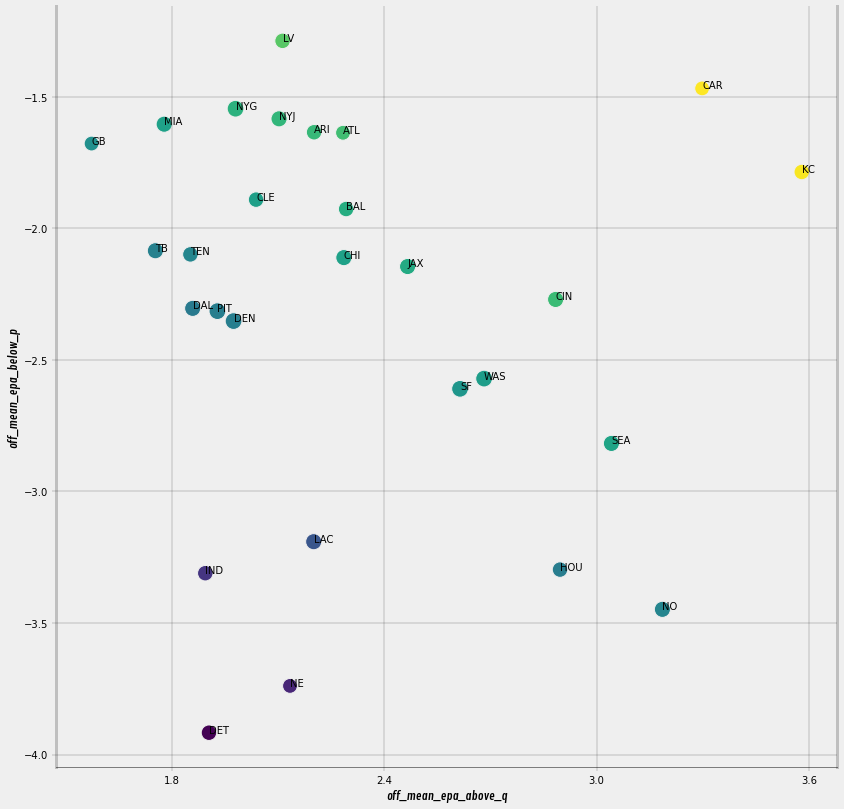

In [134]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

x_vals = 'off_mean_epa_above_q'
y_vals = 'off_mean_epa_below_p'

cmap = matplotlib.cm.get_cmap(color_map)
# norm = mpl.colors.SymLogNorm(linthresh=0.75, vmin=league_epa_min, vmax=league_epa_max)
# plot figure, axs
fig, ax = plt.subplots(figsize=(14,14))
fig.set_facecolor(background)
ax.set_facecolor(background)
#  set properties of axis
ax.patch.set_facecolor(background)
ax.grid(ls="-", lw=0.2, color=grid_color, zorder=-10)
ax.set_title("",pad=14,loc="left", color=axs_title_color, fontweight="light", fontfamily=axs_title_text, fontsize=18)
ax.set_xlabel(f"{x_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.set_ylabel(f"{y_vals}",color=axs_label_color,fontfamily=axs_label_text, fontsize=12)
ax.tick_params(axis="both",length=4, width=0.2, color=grid_color)
ax.xaxis.set_major_locator(plt.MaxNLocator(4))

spines = ["top", "right", "bottom", "left"]
for s in spines:
    if s in ["top"]:
        ax.spines[s].set_visible(False)
    elif s in ["left", "right"]:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_linewidth(3)
        ax.spines[s].set_alpha(.2)
    else:
        ax.spines[s].set_color(spines_color)
        ax.spines[s].set_alpha(.6)

weeks = [1,2,3,4,5,6,7]
weeks = [7]
# teams = ['KC','BUF']
# nfc_west = ['ARI','LA','SEA','SF']
ax.scatter(df[x_vals],df[y_vals], c=df[x_vals]+df[y_vals],cmap="viridis",edgecolors=background,s=100+(10*(df['off_qthpercentile_play_count']+df['off_pthpercentile_play_count'])), alpha=1,lw=1)
df = get_epa_info(weeks=weeks).reset_index()
for row_idx, row in df.iterrows():
#     img = getImage(team=row.posteam)
#     img.thumbnail((32, 32))
#     imagebox = OffsetImage(img)
#     imagebox.image.axes = ax
#     ab = AnnotationBbox(imagebox, [row[x_vals],row[y_vals]], frameon=False)
#     ax.add_artist(ab)
    ax.annotate(row.posteam, (row[x_vals],row[y_vals]))                

# ax.scatter(df['off_epa_mean'],df['off_epa_mean'], c=df['off_epa_mean']+df['off_epa_mean'],cmap="viridis",edgecolors=background,s=100+(10*(df['off_qthpercentile_play_count']+df['off_pthpercentile_play_count'])), alpha=1,lw=1)
# ax.scatter(df['off_epa_mean'],df['off_epa_mean'], c=df['off_epa_mean']+df['off_epa_mean'],cmap="viridis",edgecolors=background,s=100+(10*(df['off_qthpercentile_play_count']+df['off_pthpercentile_play_count'])), alpha=1,lw=1)

# ax.set_ylim(2.0,0.8)
plt.show()
            

    

In [142]:
df = df_pbp.merge(get_epa_info(df=df_pbp), on=['game_id','posteam'])

56.0


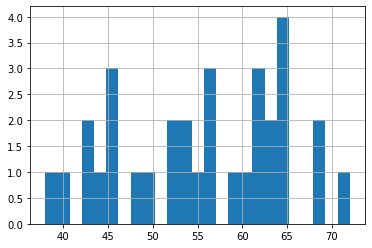

In [174]:
# teams' play count with EPAs in the league-wide's top 10th percentile of plays by EPA
(df[df.epa >= np.quantile(df.epa.dropna(), 0.9)]
 .groupby(['posteam'])
 .count()
 .epa
 .sort_values(ascending=False)
 .hist(bins=25)
)
print(df[df.epa >= np.quantile(df.epa.dropna(), 0.9)]
 .groupby(['posteam'])
 .count()
 .epa
 .sort_values(ascending=False).median()
)

posteam
DEN    71
LAC    67
IND    66
ARI    65
NO     65
DAL    65
NYJ    64
PIT    61
DET    60
WAS    60
MIA    59
CHI    59
CIN    58
SF     57
GB     57
CAR    56
LA     55
TB     53
SEA    52
CLE    52
NE     52
HOU    51
MIN    50
NYG    49
PHI    48
BAL    48
JAX    48
BUF    47
ATL    46
KC     46
LV     43
TEN    43
Name: epa, dtype: int64


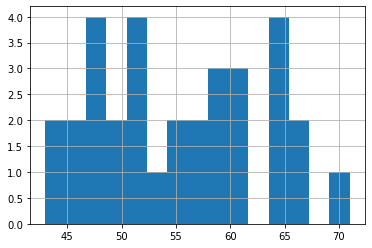

In [178]:
# teams' play count with EPAs in the league-wide's bottom 10th percentile of plays by EPA
(df[df.epa <= np.quantile(df.epa.dropna(), 0.1)]
 .groupby(['posteam'])
 .count()
 .epa
 .sort_values(ascending=False)
 .hist(bins=15)
)
print(df[df.epa <= np.quantile(df.epa.dropna(), 0.1)]
 .groupby(['posteam'])
 .count()
 .epa
 .sort_values(ascending=False)
)

In [207]:
(((df[df.epa <= np.quantile(df.epa.dropna(), 0.1)]
 .groupby(['game_id','posteam'])
 .count()
 .epa
)/(df
      .groupby(['game_id','posteam'])
      .count()
      .epa
))
 .sort_values()
 # .plot.density()
)

game_id          posteam
2022_02_MIA_BAL  BAL        0.039474
2022_01_PHI_DET  PHI        0.041237
2022_05_LAC_CLE  LAC        0.045977
2022_01_KC_ARI   KC         0.048193
2022_02_NYJ_CLE  CLE        0.048780
                              ...   
2022_05_PIT_BUF  PIT        0.164835
2022_02_TB_NO    NO         0.178571
2022_05_DAL_LA   LA         0.188235
2022_01_TB_DAL   DAL        0.195402
2022_06_NYJ_GB   GB         0.197802
Name: epa, Length: 216, dtype: float64

In [ ]:
def normEPA_btwn0and1(df_alldrives, df_week):
    min_epa = df_alldrives.epa.min()
    max_epa = df_alldrives.epa.max()
    print(min_epa,max_epa)
    return (df_week.epa-min_epa) / (max_epa - min_epa)

df_alldrives = get_offensive_drives(df=df_pbp, team='KC', weeks=[1,2,3,4,5,6,7])
df_week = get_offensive_drives(df=df_pbp, team='KC', weeks=[7])
df_notweek = get_offensive_drives(df=df_pbp, team='KC', weeks=[1,2,3,4,5,6])
week_epa_norm01 = normEPA_btwn0and1(df_alldrives, df_week)
notweek_epa_norm01 = normEPA_btwn0and1(df_alldrives, df_notweek)





fig, ax = plt.subplots(figsize=(5, 5))
ax.set_aspect('equal')

for x_quantile in np.arange(0.0,1.01,0.01):
    # x=np.quantile(df_notweek.epa, x_quantile)
    # y=np.quantile(df_week.epa, x_quantile)
    x=np.quantile(notweek_epa_norm01, x_quantile)
    y=np.quantile(week_epa_norm01, x_quantile)
    # print(x, y)
    ax.scatter(x=x,y=y)
    
ax.plot(np.arange(0.0,1.1,0.01),np.arange(0.0,1.1,0.01))
# ax.plot(np.arange(-10.0,6.0,0.5),np.arange(-10.0,6.0,0.5))

plt.show()

In [ ]:
plt.violinplot(df_notweek.epa, showmeans=True, showmedians=True,showextrema=True)

In [ ]:
sum_sq_dists =[]
clusters = range(1,10)
for k in clusters:
    kmeans = KMeans(n_clusters=k, random_state=36)
    kmeans.fit(df_teamEPA[df_teamEPA.posteam == 'SF'].epa.values.reshape(-1,1))
    sum_sq_dists.append(kmeans.inertia_)
    
plt.plot(clusters, sum_sq_dists, 'bx-')
plt.xlabel("values of k")
plt.ylabel('sum of squares distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=36)
kmeans.fit(df_teamEPA[df_teamEPA.posteam == 'SF'].epa.values.reshape(-1,1))
print(kmeans.labels_)

In [ ]:
print(kmeans.cluster_centers_)

In [ ]:
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
for n_quantile in quantiles:
    print(np.quantile(df_teamEPA[df_teamEPA.posteam == 'SF'].epa, n_quantile))

In [ ]:
df_teamEPA.loc[df_teamEPA.posteam == 'SF', 'kmeans_labels'] = kmeans.labels_

In [ ]:
plt.scatter(df_teamEPA.loc[df_teamEPA.posteam == 'SF'].kmeans_labels, df_teamEPA.loc[df_teamEPA.posteam == 'SF'].epa)